In [148]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 디버깅 모듈 설치
import pdb

In [149]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [150]:
# Hyper Parameter 지정
input_size = 3072 # 입력값이  28 x 28 x 1 / 2차원 이미지를 1차원으로 주욱 펼친 한 장의 이미지 값
hidden_size = 1800 # hidden layer의 unit 수 / 784를 다시 500으로 줄이고
num_classes = 10 # 카테고리 개수, 딥러닝 결과가 10개 나온다.손글씨의 분류는 10개 / 최종적으로는 10개가 나와야 한다. 그림
num_epochs = 10
batch_size = 100 # 이미지가 아니고 크기가 크지 않은 모델에서는 굳이 쓰일 필요가 없다.
learning_rate = 0.001

# 데이터셋 로딩 -- 2번에 걸쳐서 로딩
# 1단계 - 물리적인 위치에 데이터 저장. 다운로드(training / test)
# train_dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
# test_dataset
test_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                           train=False,
                                           transform=transforms.ToTensor())

# 2단계 - 네트워크에 100개씩 잘라서 로드함
# 2 step. DataLoader. BatchSize를 이용함.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size = batch_size,
                                           shuffle=False)

print('1',train_dataset)
print('2',test_dataset)
print('3',train_loader)

Files already downloaded and verified
1 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: ToTensor()
2 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../data
    Split: Test
    StandardTransform
Transform: ToTensor()
3 <torch.utils.data.dataloader.DataLoader object at 0x7fc0316850d0>


# Convolution NeuralNet Model 생성

In [151]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()

    self.layer1 =nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU())
    
    self.layer2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU())
    
    self.layer4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer5 = nn.Linear(8*8*64, num_classes)

  def forward(self, x):

    #pdb.set_teace() # 2
     out = self.layer1(x)
     out = self.layer2(out)
     out = self.layer3(out)
     out = self.layer4(out)
     out = out.reshape(out.size(0),-1)
     out = self.layer5(out)

     return out

In [152]:
model = ConvNet(num_classes).to(device)


In [153]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [154]:
total_step = len(train_loader)
loss_list = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # pdb.set_trace() # 2
    '''
    l(L)로 시작, q(Q)로 종료
    
    '''

    outputs = model(images).to(device)

    # pdb.set_trace() # 3


    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    
    if (i+1) % 100 == 0:
       print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/500], Loss: 1.4342
Epoch [1/10], Step [200/500], Loss: 1.4628
Epoch [1/10], Step [300/500], Loss: 1.1684
Epoch [1/10], Step [400/500], Loss: 1.1535
Epoch [1/10], Step [500/500], Loss: 1.2913
Epoch [2/10], Step [100/500], Loss: 0.9619
Epoch [2/10], Step [200/500], Loss: 0.9842
Epoch [2/10], Step [300/500], Loss: 1.0428
Epoch [2/10], Step [400/500], Loss: 0.9715
Epoch [2/10], Step [500/500], Loss: 0.9695
Epoch [3/10], Step [100/500], Loss: 0.7438
Epoch [3/10], Step [200/500], Loss: 0.6843
Epoch [3/10], Step [300/500], Loss: 0.9916
Epoch [3/10], Step [400/500], Loss: 0.9121
Epoch [3/10], Step [500/500], Loss: 0.7983
Epoch [4/10], Step [100/500], Loss: 0.7357
Epoch [4/10], Step [200/500], Loss: 0.8811
Epoch [4/10], Step [300/500], Loss: 0.9919
Epoch [4/10], Step [400/500], Loss: 0.7728
Epoch [4/10], Step [500/500], Loss: 1.0035
Epoch [5/10], Step [100/500], Loss: 0.8757
Epoch [5/10], Step [200/500], Loss: 0.7074
Epoch [5/10], Step [300/500], Loss: 0.8236
Epoch [5/10

In [155]:
model.eval()

accuracy_list = []

with torch.no_grad(): # 실제로 학습할 필요가 없으면 no.grad()구문을 넣어준다.
    correct = 0
    total = 0
    for images, labels in test_loader: # 인덱스를 굳이 안받아도 되니깐 enumeratorr가 빠졌다.
        images = images.to(device) #한줄로 죽 펼친 다음에 입력받아서
        labels = labels.to(device) # 라벨도 마찬가지로
        outputs = model(images) #모델에 넣고
        _, predicted = torch.max(outputs.data, 1)
        # total은 푼 문제, correct는 맞춘 문제수..이런식으로 카운팅이 들어간다
     
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy))
        
        accuracy_list.append(accuracy)


Test Accuracy of the model on the 10000 test images: 76.0 %
Test Accuracy of the model on the 10000 test images: 69.5 %
Test Accuracy of the model on the 10000 test images: 68.33333333333333 %
Test Accuracy of the model on the 10000 test images: 67.75 %
Test Accuracy of the model on the 10000 test images: 66.6 %
Test Accuracy of the model on the 10000 test images: 68.16666666666667 %
Test Accuracy of the model on the 10000 test images: 67.85714285714286 %
Test Accuracy of the model on the 10000 test images: 68.25 %
Test Accuracy of the model on the 10000 test images: 67.66666666666667 %
Test Accuracy of the model on the 10000 test images: 67.6 %
Test Accuracy of the model on the 10000 test images: 68.45454545454545 %
Test Accuracy of the model on the 10000 test images: 69.08333333333333 %
Test Accuracy of the model on the 10000 test images: 69.0 %
Test Accuracy of the model on the 10000 test images: 68.78571428571429 %
Test Accuracy of the model on the 10000 test images: 68.6 %
Test Ac

Label :  0
Predict :  tensor([8, 6, 6, 6, 0, 1, 1, 1, 8, 1, 4, 4, 0, 7, 8, 2, 1, 2, 5, 2, 6, 6, 6, 2,
        3, 4, 6, 9, 5, 8, 8, 0, 8, 7, 4, 1, 8, 4, 9, 5, 5, 1, 7, 3, 7, 7, 0, 3,
        8, 3, 3, 0, 5, 7, 0, 8, 2, 0, 9, 2, 0, 3, 2, 8, 4, 2, 6, 6, 5, 6, 2, 9,
        4, 0, 1, 7, 2, 3, 4, 3, 0, 4, 6, 2, 7, 3, 0, 0, 8, 2, 7, 0, 3, 3, 3, 5,
        6, 5, 4, 7], device='cuda:0')


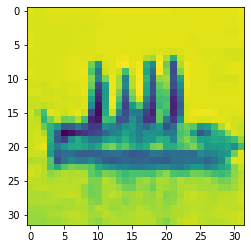

In [156]:
import numpy as np
import matplotlib.pyplot as plt

idx = 12
image = np.array(images[0,0].detach().cpu()) # 연산에서 분리시키고 gpu에서 내려준다.
label = labels[idx].item()
label
pred = predicted[idx].item()
pred

plt.imshow(image*255) # 255로 나눴기 때문에 원래대로 돌림
print('Label : ', label)
print('Predict : ', predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


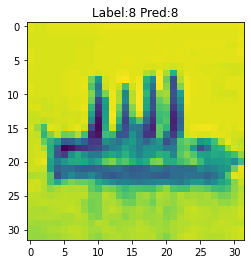

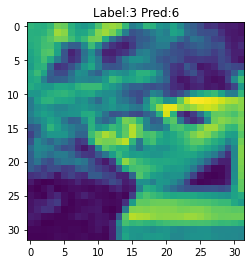

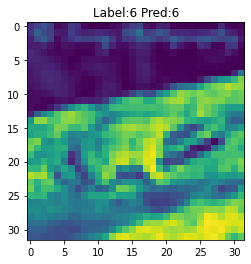

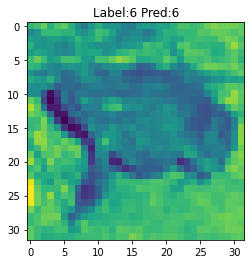

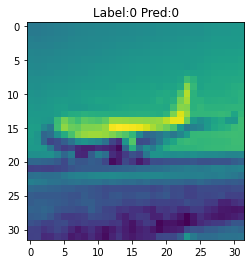

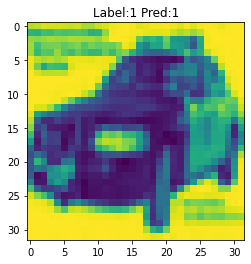

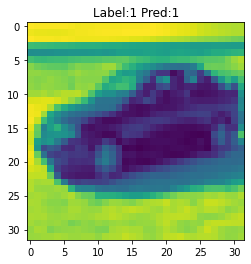

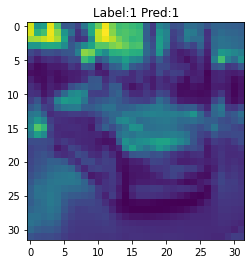

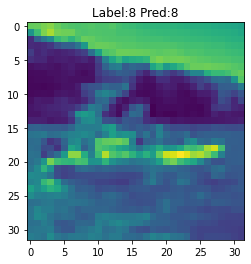

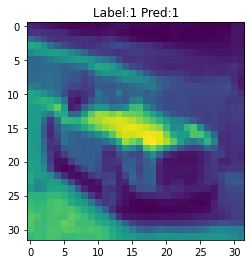

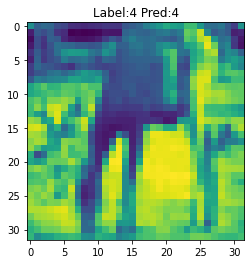

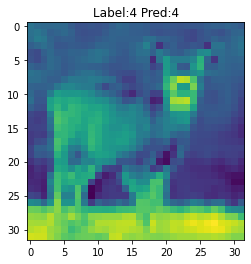

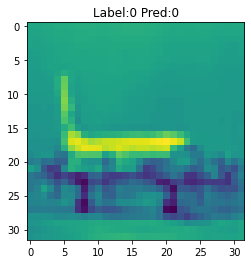

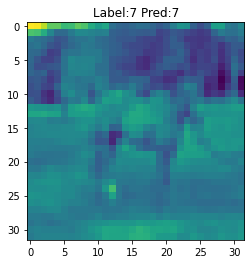

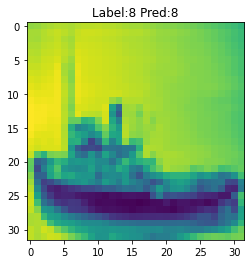

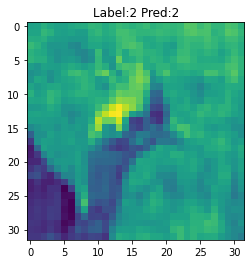

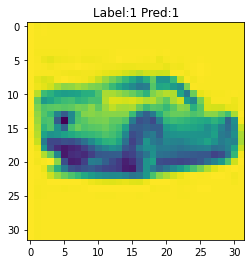

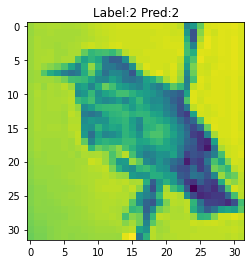

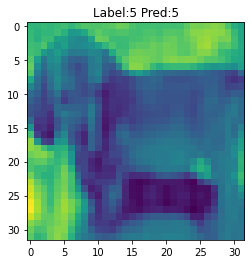

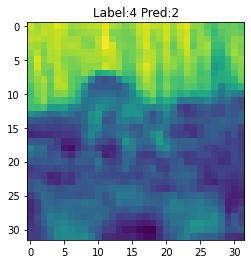

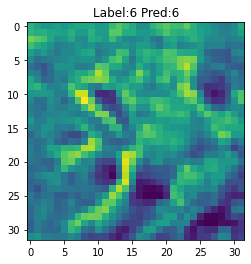

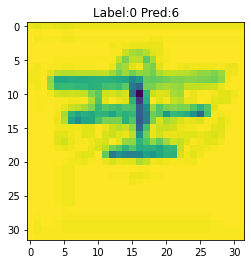

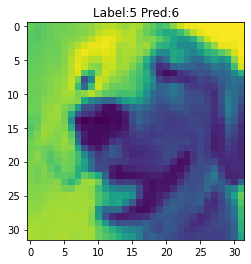

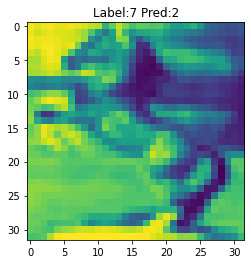

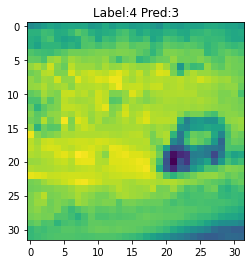

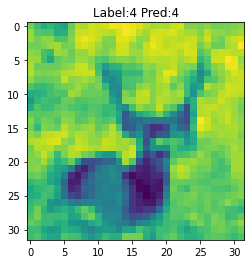

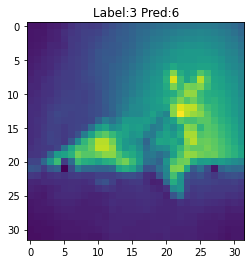

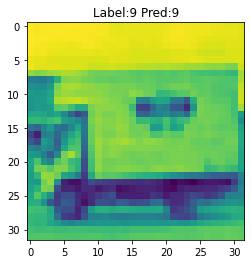

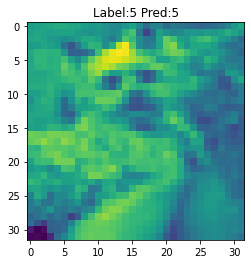

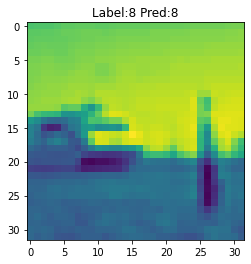

In [157]:
for idx in range(30) : 
  image = np.array(images[idx,0].detach().cpu())
  label = labels[idx].item()
  pred = predicted[idx].item()
  plt.figure()
  plt.title(f'Label:{label} Pred:{pred}')
  plt.imshow(image * 255)

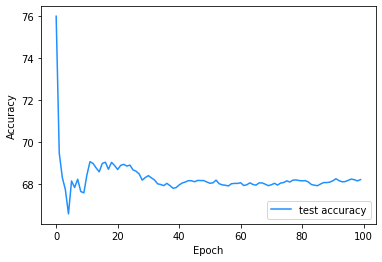

In [158]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(accuracy_list,
         label='test accuracy',
         c='dodgerblue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


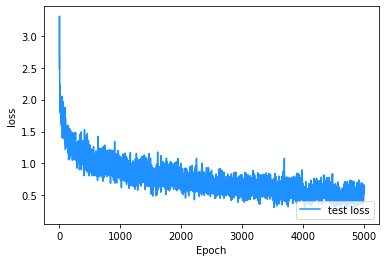

In [159]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(loss_list,
         label='test loss',
         c='dodgerblue')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()
